# 1D Burgers' Equation with PINNs

This notebook demonstrates how to solve the 1D Burgers' equation using Physics-Informed Neural Networks (PINNs).

## Problem Description
Burgers' equation describes wave propogation with **nonlinear advection and diffusion**. The 1D Burgers' equation is given by:
\begin{equation}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2},
\end{equation}
where:
- $u(x, t)$ is the velocity field,
- $ \nu $ is the viscosity coefficient.

For sinusoidal initial condition:

\begin{equation}
u(x,0) = \sin(\pi x) , 
\end{equation}

and small viscosity $\mu$, the analytical solution can be approximated as:

\begin{equation}
u(x,t) = \sin(\pi x) \exp(\mu \pi^2 t). 
\end{equation}

This solution represents a decaysing sinusoidal wave, where the amplitude decreases exponentially with time due to 
viscosity. In this notebook, we will generate data from the analytical solution and train PINNs. 

## Import Libraries

In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

## Define the Neural Network

In [6]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2,50)   # Input: (x,t)
        self.fc2 = nn.Linear(50,50)
        self.fc3 = nn.Linear(50,50)
        self.fc4 = nn.Linear(50,1)   # Output: u(x,t)

    def forward(self, x, t):
        inputs = torch.cat([x,t], dim = 1)
        out = torch.tanh(self.fc1(inputs))
        out = torch.tanh(self.fc2(out))
        out = torch.tanh(self.fc3(out))
        out = self.fc4(out)
        return out

## Define the Loss Function 

In [7]:
def pinn_loss(model, x, t, u_true, nu=0.01):
    u_pred = model(x, t)
    du_dx = torch.autograd.grad(u_pred, x, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    du_dt = torch.autograd.grad(u_pred, t, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    d2u_dx2 = torch.autograd.grad(du_dx, x, grad_outputs=torch.ones_like(du_dx), create_graph=True)[0]
    residual = du_dt + u_pred * du_dx - nu * d2u_dx2  # Burgers' equation residual
    data_loss = torch.mean((u_pred - u_true)**2)  # Data loss
    physics_loss = torch.mean(residual**2)  # Physics loss
    return physics_loss + data_loss 

## Generate Synthetic Data

In [8]:
def generate_data(nu=0.01, nx=100, nt=100, L=2.0, T=1.0):
    x = np.linspace(0, L, nx)
    t = np.linspace(0, T, nt)
    X, T = np.meshgrid(x, t)
    X = X.reshape(-1, 1)
    T = T.reshape(-1, 1)
    U = np.sin(np.pi * X) * np.exp(-nu * np.pi**2 * T)  # Analytical solution for Burgers' equation
    return X, T, U, nx, nt

## Train the model

In [14]:
def train_model():
    X, T, U, _, _ = generate_data()
    X = torch.tensor(X, dtype=torch.float32, requires_grad=True)
    T = torch.tensor(T, dtype=torch.float32, requires_grad=True)
    U = torch.tensor(U, dtype=torch.float32)

    model = PINN()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    for it in range(10000):
        optimizer.zero_grad()
        loss = pinn_loss(model, X, T, U)
        loss.backward()
        optimizer.step()

        if it % 1000 == 0:
            print(f"Iter {it:5d}, Loss: {loss.item():.4e}")

    return model

In [15]:
model = train_model()

Iter     0, Loss: 4.2121e-01
Iter  1000, Loss: 1.1818e-01
Iter  2000, Loss: 7.7568e-02
Iter  3000, Loss: 6.0649e-02
Iter  4000, Loss: 5.2965e-02
Iter  5000, Loss: 4.8484e-02
Iter  6000, Loss: 4.7579e-02
Iter  7000, Loss: 4.7217e-02
Iter  8000, Loss: 4.7026e-02
Iter  9000, Loss: 4.6925e-02


## Visualize the Results

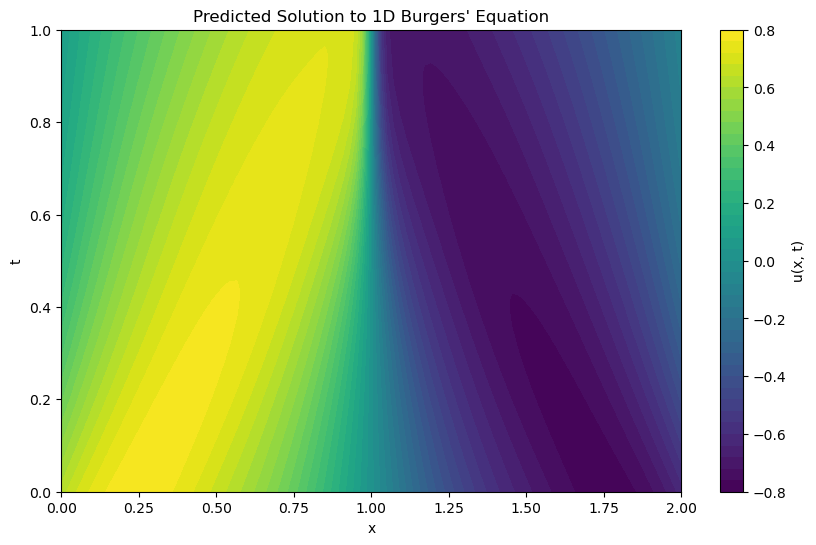

In [16]:
# Generate data
X, T, U, nx, nt = generate_data()

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32, requires_grad=True)
T_tensor = torch.tensor(T, dtype=torch.float32, requires_grad=True)

# Predict u(x, t) using the trained model
with torch.no_grad():
    u_pred = model(X_tensor, T_tensor).numpy()

# Reshape for plotting
X_plot = X.reshape(nx, nt)
T_plot = T.reshape(nx, nt)
U_plot = u_pred.reshape(nx, nt)

# Plot the results
plt.figure(figsize=(10, 6))
plt.contourf(X_plot, T_plot, U_plot, levels=50, cmap="viridis")
plt.colorbar(label="u(x, t)")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Predicted Solution to 1D Burgers' Equation")
plt.show()